In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
print(tf.__version__)

1.11.0


Task: predict the whether an ad was clicked on based on 39 anonymized factors

 - Over 45 million training examples, ~5GB

Features: 13 integer columns, followed by 26 columns of 32 bit hashed values

- Labels: Just a 0 or 1 :)

In [2]:
TRAINING_VARS = ['City', 'State', 'Country', 'Age', 'bookTitle', 'bookAuthor', 'yearOfPublication']
TARGET_VAR = ['label']

In [3]:
# load training dataset
data = pd.read_csv("./BookCrossing/data.csv")
print(data.shape)
print(data.isnull().mean())

# (661724, 8)
# City                 0.002543
# State                0.018819
# Country              0.012921
# Age                  0.000000
# bookTitle            0.000000
# bookAuthor           0.000000
# yearOfPublication    0.000000
# label                0.000000
# dtype: float64

(540629, 8)
City                 0.000723
State                0.010460
Country              0.009515
Age                  0.000000
bookTitle            0.000000
bookAuthor           0.000000
yearOfPublication    0.000000
label                0.000000
dtype: float64


In [4]:
data.head()

,City,State,Country,Age,bookTitle,bookAuthor,yearOfPublication,label
0,kln,nordrheinwestfalen,germany,27.0,along came a spider alex cross novels,james patterson,1993.0,0.0
1,kln,nordrheinwestfalen,germany,27.0,schlafes bruder,robert schneider,1994.0,0.0
2,kln,nordrheinwestfalen,germany,27.0,der stein der kelten,michael phillips,2001.0,1.0
3,kln,nordrheinwestfalen,germany,27.0,nordermoor,arnaldur indridason,2003.0,1.0
4,kln,nordrheinwestfalen,germany,27.0,nur der tod ist ohne makel,ann granger,2002.0,1.0


In [5]:
print("Unique Cities: {0} Embedding size: {1}".format(len(data.City.unique()), len(data.City.unique())** 0.25))
print("Unique State: {0} Embedding size: {1}".format(len(data.State.unique()), len(data.State.unique())** 0.25))
print("Unique Country: {0} Embedding size: {1}".format(len(data.Country.unique()), len(data.Country.unique())** 0.25))
print("Unique bookTitle: {0} Embedding size: {1}".format(len(data.bookTitle.unique()), len(data.bookTitle.unique())** 0.25))
print("Unique bookAuthor: {0} Embedding size: {1}".format(len(data.bookAuthor.unique()), len(data.bookAuthor.unique())** 0.25))

Unique Cities: 1465 Embedding size: 6.1867049726012695
Unique State: 294 Embedding size: 4.140824579655874
Unique Country: 58 Embedding size: 2.7596690210718946
Unique bookTitle: 167967 Embedding size: 20.24445041939468
Unique bookAuthor: 69785 Embedding size: 16.253261421281003


In [6]:
data = data.dropna()
print(data.shape)
print(data.isnull().sum())

(533040, 8)
City                 0
State                0
Country              0
Age                  0
bookTitle            0
bookAuthor           0
yearOfPublication    0
label                0
dtype: int64


In [7]:
data.yearOfPublication = data.yearOfPublication.astype('int64')
data.Age = data.Age.astype('int64')

In [8]:
data.head()

,City,State,Country,Age,bookTitle,bookAuthor,yearOfPublication,label
0,kln,nordrheinwestfalen,germany,27,along came a spider alex cross novels,james patterson,1993,0.0
1,kln,nordrheinwestfalen,germany,27,schlafes bruder,robert schneider,1994,0.0
2,kln,nordrheinwestfalen,germany,27,der stein der kelten,michael phillips,2001,1.0
3,kln,nordrheinwestfalen,germany,27,nordermoor,arnaldur indridason,2003,1.0
4,kln,nordrheinwestfalen,germany,27,nur der tod ist ohne makel,ann granger,2002,1.0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data[TRAINING_VARS], data[TARGET_VAR], test_size=0.10, random_state=42)

In [10]:
print(X_train.shape)
print(y_train.shape)

(479736, 7)
(479736, 1)


In [ ]:
country_categorical = tf.feature_column.categorical_column_with_vocabulary_list(key="Country",vocabulary_list=data.Country.unique())

In [11]:
city_categorical = tf.feature_column.categorical_column_with_hash_bucket(key="City", hash_bucket_size=400)
state_categorical = tf.feature_column.categorical_column_with_hash_bucket(key="State", hash_bucket_size=200) 
# country_categorical = tf.feature_column.categorical_column_with_hash_bucket(key="Country", hash_bucket_size=100)
bookTitle_categorical = tf.feature_column.categorical_column_with_hash_bucket(key="bookTitle", hash_bucket_size=1000) 
bookAuthor_categorical = tf.feature_column.categorical_column_with_hash_bucket(key="bookAuthor", hash_bucket_size=800) 

In [12]:
# Defaults to a tf.float32 scalar.
yearOfPublication_numeric = tf.feature_column.numeric_column(key="yearOfPublication")
age_numeric = tf.feature_column.numeric_column(key="Age")

In [13]:
categorical_columns = []
categorical_columns.append(tf.feature_column.bucketized_column(source_column=yearOfPublication_numeric, boundaries=[1980,1990,1995,2000,2005]))
categorical_columns.append(tf.feature_column.bucketized_column(source_column=age_numeric, boundaries=[15,20,25,30,35,40,45,50,55]))

In [14]:
embedding_columns = []
embedding_columns.append(tf.feature_column.embedding_column(categorical_column=city_categorical, dimension=8))
embedding_columns.append(tf.feature_column.embedding_column(categorical_column=state_categorical, dimension=8))
embedding_columns.append(tf.feature_column.embedding_column(categorical_column=country_categorical, dimension=8))
embedding_columns.append(tf.feature_column.embedding_column(categorical_column=bookTitle_categorical, dimension=20))
embedding_columns.append(tf.feature_column.embedding_column(categorical_column=bookAuthor_categorical, dimension=16))

In [15]:
## Feature crossing
# categorical_columns[1]: Age categorical
# Age="16" AND bookTitle="Harry Potter"
crossed_features = []
crossed_features.append(tf.feature_column.crossed_column([categorical_columns[1], "bookTitle"], 
                                                         hash_bucket_size=int(1e4)))

# Age="16" AND bookAuthor="JK Rowling"
crossed_features.append(tf.feature_column.crossed_column([categorical_columns[1], "bookAuthor"], 
                                                         hash_bucket_size=int(1e4)))

# Country="United States" AND bookTitle="Homo Deus"
crossed_features.append(tf.feature_column.crossed_column(["Country", "bookTitle"], 
                                                         hash_bucket_size=int(1e4)))

In [16]:
# Embeddings for wide columns into deep columns
for col in categorical_columns:
    embedding_columns.append(tf.feature_column.embedding_column(col, dimension=8))

In [17]:
def train_input_fn(features, labels, batch_size=512):
    # Create the dataset object and return it
    # Make sure you shuffle and define the batch size as given by the 'batch_size' parameter
    
    #   dict(features) -->
    #   {"clicked": [0,1,0,0,0,0...],
    #    "I1": [1,2,0,0,0...],
    #    "I2": [0,499,4,38,1],
    #    ...}
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.repeat(100)
    dataset = dataset.batch(batch_size)
    return dataset # return the dataset object

In [18]:
# train_input_fn = tf.estimator.inputs.pandas_input_fn(
#             x=X_train,
#             y=y_train['clicked'],
#             batch_size=64,
#             num_epochs=2,
#             shuffle=True,
#             queue_capacity=1000,
#             num_threads=1,
#             target_column='clicked')
# #map(column_name => [Tensor of values]) , [Tensor of labels])

In [19]:
# Data transformations
# crossed_1 = tf.contrib.layers.crossed_column([wide_columns[0], wide_columns[1]], 
#                                                          hash_bucket_size=int(1e4))
# wide_columns.append(crossed_1)

In [20]:
pid = os.getpid()
estimator = tf.estimator.DNNLinearCombinedClassifier(
    model_dir="./checkpoints/" + str(pid),
    # wide settings
    linear_feature_columns=categorical_columns + crossed_features,
    linear_optimizer=tf.train.FtrlOptimizer(learning_rate=0.01),
    # deep settings
    dnn_feature_columns=embedding_columns,
    dnn_hidden_units=[512, 256, 512, 128],
    dnn_optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.01),
    dnn_activation_fn=tf.nn.relu)


# estimator = tf.estimator.DNNClassifier(
#     model_dir="./checkpoints/" + str(pid),
#     feature_columns=categorical_columns + embedding_columns,
#     hidden_units=[1024, 512, 1024, 256],
#     n_classes=2,
#     optimizer=tf.train.ProximalAdagradOptimizer(
#       learning_rate=0.1,
#     ))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints/31358', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f12cdccd748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
# LOCAL. Update these paths as appropriate
# train_file = "./criteo/train_medium.csv"
# eval_file  = "./criteo/eval_small.csv"

In [22]:
print("Starting experiment:", pid)
estimator.train(input_fn=lambda: train_input_fn(X_train, y_train, batch_size=256))

Starting experiment: 31358
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./checkpoints/31358/model.ckpt.
INFO:tensorflow:loss = 175.19525, step = 1
INFO:tensorflow:global_step/sec: 66.0993
INFO:tensorflow:loss = 152.44824, step = 101 (1.514 sec)
INFO:tensorflow:global_step/sec: 120.505
INFO:tensorflow:loss = 144.86249, step = 201 (0.830 sec)
INFO:tensorflow:global_step/sec: 120.485
INFO:tensorflow:loss = 147.47821, step = 301 (0.830 sec)
INFO:tensorflow:global_step/sec: 120.475
INFO:tensorflow:loss = 133.95413, step = 401 (0.830 sec)
INFO:tensorflow:global_step/sec: 122.298
INFO:tensorflow:loss = 130.34578, step = 501 (0.818 sec)
INFO:tensorflow:global_step/sec: 124.674
INFO:tensorflow:loss = 134.41974, step = 601 (0.802 sec)
INFO:tensorflow:global_step

INFO:tensorflow:global_step/sec: 119.785
INFO:tensorflow:loss = 119.480225, step = 8001 (0.835 sec)
INFO:tensorflow:global_step/sec: 116.561
INFO:tensorflow:loss = 122.79916, step = 8101 (0.858 sec)
INFO:tensorflow:global_step/sec: 117.034
INFO:tensorflow:loss = 117.308685, step = 8201 (0.855 sec)
INFO:tensorflow:global_step/sec: 125.113
INFO:tensorflow:loss = 119.538025, step = 8301 (0.799 sec)
INFO:tensorflow:global_step/sec: 108.472
INFO:tensorflow:loss = 102.12915, step = 8401 (0.922 sec)
INFO:tensorflow:global_step/sec: 118.349
INFO:tensorflow:loss = 118.35342, step = 8501 (0.845 sec)
INFO:tensorflow:global_step/sec: 121.875
INFO:tensorflow:loss = 112.38831, step = 8601 (0.821 sec)
INFO:tensorflow:global_step/sec: 125.444
INFO:tensorflow:loss = 120.17789, step = 8701 (0.797 sec)
INFO:tensorflow:global_step/sec: 121.616
INFO:tensorflow:loss = 110.793915, step = 8801 (0.822 sec)
INFO:tensorflow:global_step/sec: 119.294
INFO:tensorflow:loss = 112.47542, step = 8901 (0.838 sec)
INFO:t

INFO:tensorflow:loss = 84.68527, step = 16201 (0.900 sec)
INFO:tensorflow:global_step/sec: 123.568
INFO:tensorflow:loss = 101.447105, step = 16301 (0.809 sec)
INFO:tensorflow:global_step/sec: 123.815
INFO:tensorflow:loss = 106.971, step = 16401 (0.808 sec)
INFO:tensorflow:global_step/sec: 124.46
INFO:tensorflow:loss = 92.37135, step = 16501 (0.804 sec)
INFO:tensorflow:global_step/sec: 125.892
INFO:tensorflow:loss = 92.25672, step = 16601 (0.794 sec)
INFO:tensorflow:global_step/sec: 125.919
INFO:tensorflow:loss = 91.34308, step = 16701 (0.794 sec)
INFO:tensorflow:global_step/sec: 124.962
INFO:tensorflow:loss = 85.60351, step = 16801 (0.800 sec)
INFO:tensorflow:global_step/sec: 125.532
INFO:tensorflow:loss = 94.85093, step = 16901 (0.798 sec)
INFO:tensorflow:global_step/sec: 125.629
INFO:tensorflow:loss = 109.121124, step = 17001 (0.795 sec)
INFO:tensorflow:global_step/sec: 124.06
INFO:tensorflow:loss = 113.59602, step = 17101 (0.806 sec)
INFO:tensorflow:global_step/sec: 125.886
INFO:ten

INFO:tensorflow:global_step/sec: 124.825
INFO:tensorflow:loss = 95.25693, step = 24501 (0.801 sec)
INFO:tensorflow:global_step/sec: 125.266
INFO:tensorflow:loss = 94.054436, step = 24601 (0.798 sec)
INFO:tensorflow:global_step/sec: 124.839
INFO:tensorflow:loss = 84.18171, step = 24701 (0.801 sec)
INFO:tensorflow:global_step/sec: 124.33
INFO:tensorflow:loss = 94.773544, step = 24801 (0.804 sec)
INFO:tensorflow:global_step/sec: 126.495
INFO:tensorflow:loss = 83.34619, step = 24901 (0.792 sec)
INFO:tensorflow:global_step/sec: 127.068
INFO:tensorflow:loss = 90.676575, step = 25001 (0.786 sec)
INFO:tensorflow:global_step/sec: 125.365
INFO:tensorflow:loss = 98.491776, step = 25101 (0.798 sec)
INFO:tensorflow:global_step/sec: 124.962
INFO:tensorflow:loss = 108.23117, step = 25201 (0.800 sec)
INFO:tensorflow:global_step/sec: 123.13
INFO:tensorflow:loss = 86.31128, step = 25301 (0.812 sec)
INFO:tensorflow:global_step/sec: 125.474
INFO:tensorflow:loss = 80.87108, step = 25401 (0.797 sec)
INFO:te

INFO:tensorflow:global_step/sec: 106.055
INFO:tensorflow:loss = 72.64976, step = 32801 (0.944 sec)
INFO:tensorflow:global_step/sec: 107.6
INFO:tensorflow:loss = 76.09609, step = 32901 (0.928 sec)
INFO:tensorflow:global_step/sec: 104.373
INFO:tensorflow:loss = 78.681564, step = 33001 (0.960 sec)
INFO:tensorflow:global_step/sec: 100.768
INFO:tensorflow:loss = 83.80344, step = 33101 (0.991 sec)
INFO:tensorflow:global_step/sec: 108.118
INFO:tensorflow:loss = 79.48906, step = 33201 (0.926 sec)
INFO:tensorflow:global_step/sec: 110.387
INFO:tensorflow:loss = 81.38893, step = 33301 (0.905 sec)
INFO:tensorflow:global_step/sec: 110.35
INFO:tensorflow:loss = 72.837906, step = 33401 (0.906 sec)
INFO:tensorflow:global_step/sec: 106.892
INFO:tensorflow:loss = 80.84316, step = 33501 (0.936 sec)
INFO:tensorflow:global_step/sec: 110.26
INFO:tensorflow:loss = 78.02931, step = 33601 (0.907 sec)
INFO:tensorflow:global_step/sec: 108.042
INFO:tensorflow:loss = 74.8795, step = 33701 (0.925 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 121.321
INFO:tensorflow:loss = 69.75329, step = 41101 (0.824 sec)
INFO:tensorflow:global_step/sec: 116.479
INFO:tensorflow:loss = 72.72529, step = 41201 (0.859 sec)
INFO:tensorflow:global_step/sec: 95.2988
INFO:tensorflow:loss = 59.856827, step = 41301 (1.050 sec)
INFO:tensorflow:global_step/sec: 114.678
INFO:tensorflow:loss = 79.566986, step = 41401 (0.872 sec)
INFO:tensorflow:global_step/sec: 116.608
INFO:tensorflow:loss = 79.924286, step = 41501 (0.858 sec)
INFO:tensorflow:global_step/sec: 119.504
INFO:tensorflow:loss = 61.44532, step = 41601 (0.837 sec)
INFO:tensorflow:global_step/sec: 122.383
INFO:tensorflow:loss = 57.537296, step = 41701 (0.817 sec)
INFO:tensorflow:global_step/sec: 116.146
INFO:tensorflow:loss = 68.74689, step = 41801 (0.861 sec)
INFO:tensorflow:global_step/sec: 119.174
INFO:tensorflow:loss = 60.320473, step = 41901 (0.839 sec)
INFO:tensorflow:global_step/sec: 120.055
INFO:tensorflow:loss = 74.05814, step = 42001 (0.833 sec)
INFO:

INFO:tensorflow:global_step/sec: 122.35
INFO:tensorflow:loss = 57.1512, step = 49401 (0.817 sec)
INFO:tensorflow:global_step/sec: 123.115
INFO:tensorflow:loss = 56.650085, step = 49501 (0.813 sec)
INFO:tensorflow:global_step/sec: 122.601
INFO:tensorflow:loss = 78.80095, step = 49601 (0.816 sec)
INFO:tensorflow:global_step/sec: 124.997
INFO:tensorflow:loss = 80.249405, step = 49701 (0.799 sec)
INFO:tensorflow:global_step/sec: 123.958
INFO:tensorflow:loss = 48.508385, step = 49801 (0.808 sec)
INFO:tensorflow:global_step/sec: 107.481
INFO:tensorflow:loss = 53.08497, step = 49901 (0.929 sec)
INFO:tensorflow:global_step/sec: 100.404
INFO:tensorflow:loss = 69.439354, step = 50001 (0.996 sec)
INFO:tensorflow:global_step/sec: 108.517
INFO:tensorflow:loss = 59.901398, step = 50101 (0.922 sec)
INFO:tensorflow:global_step/sec: 111.601
INFO:tensorflow:loss = 77.59933, step = 50201 (0.896 sec)
INFO:tensorflow:global_step/sec: 108.275
INFO:tensorflow:loss = 61.693295, step = 50301 (0.925 sec)
INFO:t

INFO:tensorflow:global_step/sec: 125.635
INFO:tensorflow:loss = 56.564934, step = 57701 (0.796 sec)
INFO:tensorflow:global_step/sec: 109.388
INFO:tensorflow:loss = 59.212494, step = 57801 (0.914 sec)
INFO:tensorflow:global_step/sec: 122.635
INFO:tensorflow:loss = 51.11708, step = 57901 (0.816 sec)
INFO:tensorflow:global_step/sec: 106.497
INFO:tensorflow:loss = 46.062325, step = 58001 (0.939 sec)
INFO:tensorflow:global_step/sec: 109.37
INFO:tensorflow:loss = 66.94138, step = 58101 (0.915 sec)
INFO:tensorflow:global_step/sec: 117.206
INFO:tensorflow:loss = 47.534283, step = 58201 (0.851 sec)
INFO:tensorflow:global_step/sec: 103.237
INFO:tensorflow:loss = 50.60502, step = 58301 (0.969 sec)
INFO:tensorflow:global_step/sec: 88.8775
INFO:tensorflow:loss = 60.700874, step = 58401 (1.125 sec)
INFO:tensorflow:global_step/sec: 97.3092
INFO:tensorflow:loss = 59.778885, step = 58501 (1.028 sec)
INFO:tensorflow:global_step/sec: 108.87
INFO:tensorflow:loss = 49.17014, step = 58601 (0.918 sec)
INFO:t

INFO:tensorflow:loss = 49.59267, step = 65901 (0.879 sec)
INFO:tensorflow:global_step/sec: 115.973
INFO:tensorflow:loss = 45.525475, step = 66001 (0.863 sec)
INFO:tensorflow:global_step/sec: 112.43
INFO:tensorflow:loss = 47.347046, step = 66101 (0.889 sec)
INFO:tensorflow:global_step/sec: 108.414
INFO:tensorflow:loss = 48.073307, step = 66201 (0.922 sec)
INFO:tensorflow:global_step/sec: 111.476
INFO:tensorflow:loss = 36.27333, step = 66301 (0.897 sec)
INFO:tensorflow:global_step/sec: 111.427
INFO:tensorflow:loss = 54.520042, step = 66401 (0.898 sec)
INFO:tensorflow:global_step/sec: 109.688
INFO:tensorflow:loss = 43.383682, step = 66501 (0.911 sec)
INFO:tensorflow:global_step/sec: 109.042
INFO:tensorflow:loss = 53.35125, step = 66601 (0.917 sec)
INFO:tensorflow:global_step/sec: 114.079
INFO:tensorflow:loss = 55.576836, step = 66701 (0.877 sec)
INFO:tensorflow:global_step/sec: 114.729
INFO:tensorflow:loss = 78.37663, step = 66801 (0.871 sec)
INFO:tensorflow:global_step/sec: 108.31
INFO:t

INFO:tensorflow:global_step/sec: 118.807
INFO:tensorflow:loss = 37.397964, step = 74101 (0.841 sec)
INFO:tensorflow:global_step/sec: 105.901
INFO:tensorflow:loss = 48.00695, step = 74201 (0.948 sec)
INFO:tensorflow:global_step/sec: 105.028
INFO:tensorflow:loss = 38.0948, step = 74301 (0.949 sec)
INFO:tensorflow:global_step/sec: 115.486
INFO:tensorflow:loss = 42.064487, step = 74401 (0.866 sec)
INFO:tensorflow:global_step/sec: 98.2271
INFO:tensorflow:loss = 49.742615, step = 74501 (1.018 sec)
INFO:tensorflow:global_step/sec: 108.492
INFO:tensorflow:loss = 58.42271, step = 74601 (0.922 sec)
INFO:tensorflow:global_step/sec: 115.203
INFO:tensorflow:loss = 52.262535, step = 74701 (0.868 sec)
INFO:tensorflow:global_step/sec: 123.287
INFO:tensorflow:loss = 23.850758, step = 74801 (0.811 sec)
INFO:tensorflow:global_step/sec: 118.275
INFO:tensorflow:loss = 35.954384, step = 74901 (0.846 sec)
INFO:tensorflow:global_step/sec: 120.259
INFO:tensorflow:loss = 28.46612, step = 75001 (0.831 sec)
INFO:

INFO:tensorflow:loss = 39.227837, step = 82301 (0.805 sec)
INFO:tensorflow:global_step/sec: 107.797
INFO:tensorflow:loss = 45.421753, step = 82401 (0.927 sec)
INFO:tensorflow:global_step/sec: 95.6244
INFO:tensorflow:loss = 41.18444, step = 82501 (1.046 sec)
INFO:tensorflow:global_step/sec: 105.662
INFO:tensorflow:loss = 41.13475, step = 82601 (0.948 sec)
INFO:tensorflow:global_step/sec: 98.6217
INFO:tensorflow:loss = 48.000694, step = 82701 (1.012 sec)
INFO:tensorflow:global_step/sec: 116.957
INFO:tensorflow:loss = 26.095066, step = 82801 (0.855 sec)
INFO:tensorflow:global_step/sec: 115.466
INFO:tensorflow:loss = 28.235203, step = 82901 (0.867 sec)
INFO:tensorflow:global_step/sec: 111.07
INFO:tensorflow:loss = 33.97342, step = 83001 (0.899 sec)
INFO:tensorflow:global_step/sec: 104.003
INFO:tensorflow:loss = 30.362516, step = 83101 (0.961 sec)
INFO:tensorflow:global_step/sec: 110.485
INFO:tensorflow:loss = 35.287903, step = 83201 (0.905 sec)
INFO:tensorflow:global_step/sec: 120.21
INFO:

INFO:tensorflow:global_step/sec: 123.248
INFO:tensorflow:loss = 49.37656, step = 90601 (0.811 sec)
INFO:tensorflow:global_step/sec: 125.059
INFO:tensorflow:loss = 22.75763, step = 90701 (0.800 sec)
INFO:tensorflow:global_step/sec: 120.849
INFO:tensorflow:loss = 27.870617, step = 90801 (0.828 sec)
INFO:tensorflow:global_step/sec: 124.141
INFO:tensorflow:loss = 32.177464, step = 90901 (0.806 sec)
INFO:tensorflow:global_step/sec: 123.37
INFO:tensorflow:loss = 59.33117, step = 91001 (0.811 sec)
INFO:tensorflow:global_step/sec: 124.245
INFO:tensorflow:loss = 29.582747, step = 91101 (0.805 sec)
INFO:tensorflow:global_step/sec: 121.429
INFO:tensorflow:loss = 29.940243, step = 91201 (0.824 sec)
INFO:tensorflow:global_step/sec: 123.055
INFO:tensorflow:loss = 43.198887, step = 91301 (0.812 sec)
INFO:tensorflow:global_step/sec: 121.412
INFO:tensorflow:loss = 30.410025, step = 91401 (0.824 sec)
INFO:tensorflow:global_step/sec: 122.172
INFO:tensorflow:loss = 28.918968, step = 91501 (0.818 sec)
INFO

INFO:tensorflow:loss = 32.13609, step = 98801 (0.928 sec)
INFO:tensorflow:global_step/sec: 97.5536
INFO:tensorflow:loss = 38.129883, step = 98901 (1.025 sec)
INFO:tensorflow:global_step/sec: 120.941
INFO:tensorflow:loss = 37.535904, step = 99001 (0.827 sec)
INFO:tensorflow:global_step/sec: 124.691
INFO:tensorflow:loss = 30.091625, step = 99101 (0.802 sec)
INFO:tensorflow:global_step/sec: 113.111
INFO:tensorflow:loss = 32.741173, step = 99201 (0.884 sec)
INFO:tensorflow:global_step/sec: 126.101
INFO:tensorflow:loss = 31.86903, step = 99301 (0.793 sec)
INFO:tensorflow:global_step/sec: 126.324
INFO:tensorflow:loss = 45.722008, step = 99401 (0.791 sec)
INFO:tensorflow:global_step/sec: 124.436
INFO:tensorflow:loss = 37.246468, step = 99501 (0.804 sec)
INFO:tensorflow:global_step/sec: 118.281
INFO:tensorflow:loss = 31.547443, step = 99601 (0.845 sec)
INFO:tensorflow:global_step/sec: 123.411
INFO:tensorflow:loss = 35.493454, step = 99701 (0.810 sec)
INFO:tensorflow:global_step/sec: 111.14
INF

INFO:tensorflow:global_step/sec: 125.583
INFO:tensorflow:loss = 26.90455, step = 107001 (0.796 sec)
INFO:tensorflow:global_step/sec: 117.564
INFO:tensorflow:loss = 23.109764, step = 107101 (0.851 sec)
INFO:tensorflow:global_step/sec: 124.852
INFO:tensorflow:loss = 22.134945, step = 107201 (0.801 sec)
INFO:tensorflow:global_step/sec: 122.566
INFO:tensorflow:loss = 31.569271, step = 107301 (0.816 sec)
INFO:tensorflow:global_step/sec: 109.874
INFO:tensorflow:loss = 23.453514, step = 107401 (0.910 sec)
INFO:tensorflow:global_step/sec: 110.385
INFO:tensorflow:loss = 39.288754, step = 107501 (0.906 sec)
INFO:tensorflow:global_step/sec: 120.003
INFO:tensorflow:loss = 27.96708, step = 107601 (0.833 sec)
INFO:tensorflow:global_step/sec: 124.82
INFO:tensorflow:loss = 33.280704, step = 107701 (0.801 sec)
INFO:tensorflow:global_step/sec: 124.547
INFO:tensorflow:loss = 24.688515, step = 107801 (0.803 sec)
INFO:tensorflow:global_step/sec: 113.273
INFO:tensorflow:loss = 32.38293, step = 107901 (0.883

INFO:tensorflow:global_step/sec: 79.1596
INFO:tensorflow:loss = 33.330566, step = 115201 (1.265 sec)
INFO:tensorflow:global_step/sec: 93.2615
INFO:tensorflow:loss = 21.724573, step = 115301 (1.071 sec)
INFO:tensorflow:global_step/sec: 118.243
INFO:tensorflow:loss = 23.060242, step = 115401 (0.846 sec)
INFO:tensorflow:global_step/sec: 122.51
INFO:tensorflow:loss = 18.615595, step = 115501 (0.816 sec)
INFO:tensorflow:global_step/sec: 116.368
INFO:tensorflow:loss = 40.33606, step = 115601 (0.859 sec)
INFO:tensorflow:global_step/sec: 107.443
INFO:tensorflow:loss = 23.90439, step = 115701 (0.931 sec)
INFO:tensorflow:global_step/sec: 106.786
INFO:tensorflow:loss = 25.278526, step = 115801 (0.938 sec)
INFO:tensorflow:global_step/sec: 101.469
INFO:tensorflow:loss = 18.315845, step = 115901 (0.984 sec)
INFO:tensorflow:global_step/sec: 122.016
INFO:tensorflow:loss = 30.205536, step = 116001 (0.819 sec)
INFO:tensorflow:global_step/sec: 122.965
INFO:tensorflow:loss = 20.496899, step = 116101 (0.81

INFO:tensorflow:loss = 22.970938, step = 123301 (0.863 sec)
INFO:tensorflow:global_step/sec: 113.666
INFO:tensorflow:loss = 21.480936, step = 123401 (0.880 sec)
INFO:tensorflow:global_step/sec: 114.734
INFO:tensorflow:loss = 18.886711, step = 123501 (0.871 sec)
INFO:tensorflow:global_step/sec: 114.304
INFO:tensorflow:loss = 27.695612, step = 123601 (0.876 sec)
INFO:tensorflow:global_step/sec: 125.163
INFO:tensorflow:loss = 27.071035, step = 123701 (0.799 sec)
INFO:tensorflow:global_step/sec: 108.354
INFO:tensorflow:loss = 28.12043, step = 123801 (0.922 sec)
INFO:tensorflow:global_step/sec: 125.014
INFO:tensorflow:loss = 22.340979, step = 123901 (0.800 sec)
INFO:tensorflow:global_step/sec: 124.55
INFO:tensorflow:loss = 28.299461, step = 124001 (0.803 sec)
INFO:tensorflow:global_step/sec: 125.083
INFO:tensorflow:loss = 32.89524, step = 124101 (0.800 sec)
INFO:tensorflow:global_step/sec: 124.501
INFO:tensorflow:loss = 27.604958, step = 124201 (0.803 sec)
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:global_step/sec: 113.264
INFO:tensorflow:loss = 19.255402, step = 131501 (0.883 sec)
INFO:tensorflow:global_step/sec: 91.4318
INFO:tensorflow:loss = 19.585552, step = 131601 (1.094 sec)
INFO:tensorflow:global_step/sec: 120.415
INFO:tensorflow:loss = 23.225798, step = 131701 (0.831 sec)
INFO:tensorflow:global_step/sec: 123.023
INFO:tensorflow:loss = 15.337993, step = 131801 (0.813 sec)
INFO:tensorflow:global_step/sec: 122.964
INFO:tensorflow:loss = 27.957932, step = 131901 (0.813 sec)
INFO:tensorflow:global_step/sec: 123.22
INFO:tensorflow:loss = 16.287632, step = 132001 (0.812 sec)
INFO:tensorflow:global_step/sec: 122.818
INFO:tensorflow:loss = 13.936811, step = 132101 (0.814 sec)
INFO:tensorflow:global_step/sec: 94.0772
INFO:tensorflow:loss = 16.35119, step = 132201 (1.063 sec)
INFO:tensorflow:global_step/sec: 114.897
INFO:tensorflow:loss = 25.743969, step = 132301 (0.871 sec)
INFO:tensorflow:global_step/sec: 107.085
INFO:tensorflow:loss = 14.555132, step = 132401 (0.9

INFO:tensorflow:global_step/sec: 124.333
INFO:tensorflow:loss = 17.093842, step = 139601 (0.804 sec)
INFO:tensorflow:global_step/sec: 117.594
INFO:tensorflow:loss = 17.31495, step = 139701 (0.850 sec)
INFO:tensorflow:global_step/sec: 101.743
INFO:tensorflow:loss = 14.911878, step = 139801 (0.983 sec)
INFO:tensorflow:global_step/sec: 114.579
INFO:tensorflow:loss = 18.489124, step = 139901 (0.873 sec)
INFO:tensorflow:global_step/sec: 121.845
INFO:tensorflow:loss = 14.579503, step = 140001 (0.820 sec)
INFO:tensorflow:global_step/sec: 102.632
INFO:tensorflow:loss = 23.973671, step = 140101 (0.975 sec)
INFO:tensorflow:global_step/sec: 105.131
INFO:tensorflow:loss = 18.190876, step = 140201 (0.951 sec)
INFO:tensorflow:global_step/sec: 114.092
INFO:tensorflow:loss = 8.346159, step = 140301 (0.877 sec)
INFO:tensorflow:global_step/sec: 110.826
INFO:tensorflow:loss = 16.434093, step = 140401 (0.902 sec)
INFO:tensorflow:global_step/sec: 111.696
INFO:tensorflow:loss = 19.586966, step = 140501 (0.8

INFO:tensorflow:loss = 14.172928, step = 147701 (0.962 sec)
INFO:tensorflow:global_step/sec: 100.859
INFO:tensorflow:loss = 12.837847, step = 147801 (0.991 sec)
INFO:tensorflow:global_step/sec: 123.063
INFO:tensorflow:loss = 20.777103, step = 147901 (0.813 sec)
INFO:tensorflow:global_step/sec: 107.402
INFO:tensorflow:loss = 18.011986, step = 148001 (0.932 sec)
INFO:tensorflow:global_step/sec: 111.759
INFO:tensorflow:loss = 21.70551, step = 148101 (0.894 sec)
INFO:tensorflow:global_step/sec: 99.494
INFO:tensorflow:loss = 16.746365, step = 148201 (1.007 sec)
INFO:tensorflow:global_step/sec: 117.496
INFO:tensorflow:loss = 18.917309, step = 148301 (0.851 sec)
INFO:tensorflow:global_step/sec: 111.628
INFO:tensorflow:loss = 18.890759, step = 148401 (0.895 sec)
INFO:tensorflow:global_step/sec: 119.046
INFO:tensorflow:loss = 18.018328, step = 148501 (0.839 sec)
INFO:tensorflow:global_step/sec: 123.088
INFO:tensorflow:loss = 12.66438, step = 148601 (0.813 sec)
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:global_step/sec: 124.081
INFO:tensorflow:loss = 9.411878, step = 155901 (0.806 sec)
INFO:tensorflow:global_step/sec: 119.967
INFO:tensorflow:loss = 24.54394, step = 156001 (0.833 sec)
INFO:tensorflow:global_step/sec: 122.192
INFO:tensorflow:loss = 14.537004, step = 156101 (0.820 sec)
INFO:tensorflow:global_step/sec: 117.901
INFO:tensorflow:loss = 16.187767, step = 156201 (0.847 sec)
INFO:tensorflow:global_step/sec: 126.358
INFO:tensorflow:loss = 20.769463, step = 156301 (0.793 sec)
INFO:tensorflow:global_step/sec: 123.468
INFO:tensorflow:loss = 7.964565, step = 156401 (0.809 sec)
INFO:tensorflow:global_step/sec: 121.814
INFO:tensorflow:loss = 13.625355, step = 156501 (0.821 sec)
INFO:tensorflow:global_step/sec: 124.98
INFO:tensorflow:loss = 9.077017, step = 156601 (0.800 sec)
INFO:tensorflow:global_step/sec: 124.939
INFO:tensorflow:loss = 10.318545, step = 156701 (0.801 sec)
INFO:tensorflow:global_step/sec: 119.587
INFO:tensorflow:loss = 9.980402, step = 156801 (0.838 s

INFO:tensorflow:global_step/sec: 125.699
INFO:tensorflow:loss = 13.625574, step = 164101 (0.795 sec)
INFO:tensorflow:global_step/sec: 122.363
INFO:tensorflow:loss = 8.760682, step = 164201 (0.817 sec)
INFO:tensorflow:global_step/sec: 124.065
INFO:tensorflow:loss = 22.343266, step = 164301 (0.806 sec)
INFO:tensorflow:global_step/sec: 110.323
INFO:tensorflow:loss = 10.118198, step = 164401 (0.907 sec)
INFO:tensorflow:global_step/sec: 122.61
INFO:tensorflow:loss = 13.477486, step = 164501 (0.815 sec)
INFO:tensorflow:global_step/sec: 122.268
INFO:tensorflow:loss = 10.003378, step = 164601 (0.819 sec)
INFO:tensorflow:global_step/sec: 122.583
INFO:tensorflow:loss = 21.128317, step = 164701 (0.814 sec)
INFO:tensorflow:global_step/sec: 119.892
INFO:tensorflow:loss = 19.298046, step = 164801 (0.834 sec)
INFO:tensorflow:global_step/sec: 123.859
INFO:tensorflow:loss = 10.667274, step = 164901 (0.807 sec)
INFO:tensorflow:global_step/sec: 120.065
INFO:tensorflow:loss = 13.196932, step = 165001 (0.8

INFO:tensorflow:loss = 6.1299367, step = 172201 (0.817 sec)
INFO:tensorflow:global_step/sec: 123.59
INFO:tensorflow:loss = 15.592361, step = 172301 (0.809 sec)
INFO:tensorflow:global_step/sec: 124.406
INFO:tensorflow:loss = 8.863945, step = 172401 (0.804 sec)
INFO:tensorflow:global_step/sec: 124.677
INFO:tensorflow:loss = 9.837054, step = 172501 (0.802 sec)
INFO:tensorflow:global_step/sec: 123.049
INFO:tensorflow:loss = 12.426098, step = 172601 (0.813 sec)
INFO:tensorflow:global_step/sec: 124.391
INFO:tensorflow:loss = 16.44451, step = 172701 (0.804 sec)
INFO:tensorflow:global_step/sec: 123.597
INFO:tensorflow:loss = 17.065018, step = 172801 (0.809 sec)
INFO:tensorflow:global_step/sec: 124.267
INFO:tensorflow:loss = 17.129625, step = 172901 (0.805 sec)
INFO:tensorflow:global_step/sec: 123.826
INFO:tensorflow:loss = 11.83535, step = 173001 (0.808 sec)
INFO:tensorflow:global_step/sec: 123.846
INFO:tensorflow:loss = 9.120163, step = 173101 (0.807 sec)
INFO:tensorflow:global_step/sec: 123.

INFO:tensorflow:global_step/sec: 122.866
INFO:tensorflow:loss = 11.9924965, step = 180401 (0.813 sec)
INFO:tensorflow:global_step/sec: 122.216
INFO:tensorflow:loss = 8.134718, step = 180501 (0.818 sec)
INFO:tensorflow:global_step/sec: 123.661
INFO:tensorflow:loss = 8.0497055, step = 180601 (0.809 sec)
INFO:tensorflow:global_step/sec: 117.873
INFO:tensorflow:loss = 18.31755, step = 180701 (0.848 sec)
INFO:tensorflow:global_step/sec: 107.676
INFO:tensorflow:loss = 7.5592856, step = 180801 (0.929 sec)
INFO:tensorflow:global_step/sec: 123.261
INFO:tensorflow:loss = 9.6028, step = 180901 (0.811 sec)
INFO:tensorflow:global_step/sec: 114.233
INFO:tensorflow:loss = 12.695652, step = 181001 (0.875 sec)
INFO:tensorflow:global_step/sec: 124.923
INFO:tensorflow:loss = 14.718497, step = 181101 (0.801 sec)
INFO:tensorflow:global_step/sec: 122.769
INFO:tensorflow:loss = 16.756334, step = 181201 (0.815 sec)
INFO:tensorflow:global_step/sec: 124.372
INFO:tensorflow:loss = 10.226107, step = 181301 (0.804

## EVAL model accuracy

In [23]:
print("Test/input data shape:",X_test.shape)
print("Test/labels data shape:",y_test.shape)

Test/input data shape: (53304, 7)
Test/labels data shape: (53304, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12bc1144a8>]],
      dtype=object)

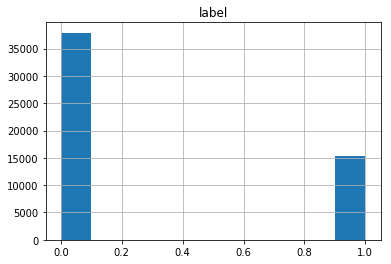

In [24]:
# the dataset is unbalanced. There are much more records with label 0 (not clicked) than 1
y_test.hist()

In [25]:
eval_input_fn = tf.estimator.inputs.pandas_input_fn(
            x=X_test,
            y=y_test['label'],
            batch_size=400,
            num_epochs=4,
            shuffle=False,
            queue_capacity=1000,
            num_threads=1,
            target_column='label')

In [26]:
estimator.evaluate(input_fn=eval_input_fn)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-19-20:06:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints/31358/model.ckpt-187397
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Finished evaluation at 2018-10-19-20:06:09
INFO:tensorflow:Saving dict for global step 187397: accuracy = 0.6992158, accuracy_baseline = 0.71125996, auc = 0.6637502, auc_precision_recall = 0.53572035, average_loss = 2.8169253, global_step = 187397, label/mean = 0.28874007, loss = 1124.7445, precision = 0.47930902, prediction/mean = 0.29758713, recall = 0.4831395
INFO:tensorflow:Saving 'checkpoint_pat

{'accuracy': 0.6992158,
 'accuracy_baseline': 0.71125996,
 'auc': 0.6637502,
 'auc_precision_recall': 0.53572035,
 'average_loss': 2.8169253,
 'label/mean': 0.28874007,
 'loss': 1124.7445,
 'precision': 0.47930902,
 'prediction/mean': 0.29758713,
 'recall': 0.4831395,
 'global_step': 187397}

In [27]:
predictions = estimator.predict(eval_input_fn)

In [28]:
for i, pred in enumerate(predictions):
    print(pred['class_ids'], y_test.values[i])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./checkpoints/31358/model.ckpt-187397
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.

[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[

[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [1.]
[

[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[

[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[

[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[

[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[

[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[

[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[

[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[

[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[

[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[

[0] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[

[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [1.]
[

[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[

[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [1.]
[

[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [1.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[

[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[

[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[

[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[

[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[

[0] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[

[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[

[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[

[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [1.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[

[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[

[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[0] [0.]
[0] [1.]
[

[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [0.]
[1] [0.]
[0] [1.]
[0] [1.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[

IndexError: index 53304 is out of bounds for axis 0 with size 53304